#### In this NB we develop a method for determining which features are predicitve of cluster ID using SHAP values...

Originally we used an intentionally overfitted classifier, but this is probably less informative than a well trained RF?

In fact, the RF with some hyperparameter selection to reduce overfit seemed to give very similar results, but this needs investigating further.

In [16]:
import pandas as pd
import numpy as np
import pickle
import shap

from utilities import load_communities, load_symptom_data

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = load_symptom_data('../data/cleaned_data_SYMPTOMS_9_13_23.csv')

In [3]:
communities = load_communities('./graphs/full_patient_relative_graph_louvain_communities_gamma_1.pickle')

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
def get_community(i, parition):
    for pi, part in enumerate(parition):
        if i in part:
            return pi

    return -1

In [6]:
y = [
    get_community(r[0], communities)
    for r in  train.iterrows()
]

In [7]:
(np.array(y)==1).sum()

547

##### We either fit an RF classifier 'properly' using CV for hyperparamter selection:

In [8]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [25, 50, 75],
    'criterion' :['gini']#, 'entropy']
}

In [9]:
rf=RandomForestClassifier(random_state=42)

In [10]:
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)

In [11]:
CV_rf.fit(train, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [25, 50, 75],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [12]:
CV_rf.best_score_

0.8925549001746308

In [13]:
CV_rf.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'log2',
 'n_estimators': 200}

In [17]:
explainer = shap.TreeExplainer(CV_rf.best_estimator_)

In [18]:
shap_values_tuned = explainer(train)

##### Or we deliberately overfit to get perfect predictions.

##### Note: Not sure yet which approach works best. Probably the cross-validation, but need to try both on a better set of clusters.

In [19]:
# clf = RandomForestClassifier()
# clf.fit(train, y)
# clf.score(train, y)
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer(train)

In [21]:
shap_values_tuned.values.shape

(6031, 162, 3)

##### We can get a sense of global feature importance from the RF itself, but these are not cluster specific:

In [22]:
# fimp = pd.DataFrame(clf.feature_importances_, columns=['importance'], index=train.columns).sort_values(by='importance', ascending=False)
fimp = pd.DataFrame(CV_rf.best_estimator_.feature_importances_, columns=['importance'], index=train.columns).sort_values(by='importance', ascending=False)

In [29]:
fimp

,importance
Symptom_Speech_difficulty_finding_words,0.027091
Symptom_Eye_Vision_blurred_vision,0.025626
Symptom_Eye_vision_symptoms,0.023220
Symptom_Eye_Vision_sensitivity_to_light,0.023081
Symptom_Speech_difficulty_understanding_others_speech,0.020409
...,...
Symptom_Reproductive_postmenopausal_bleeding,0.000603
Symptom_Hallucinations_other,0.000506
Symptom_Reproductive_early_menopause,0.000453
Symptom_Eye_Vision_loss_of_vision,0.000266


##### So we want to look at the SHAP values by cluster/community:

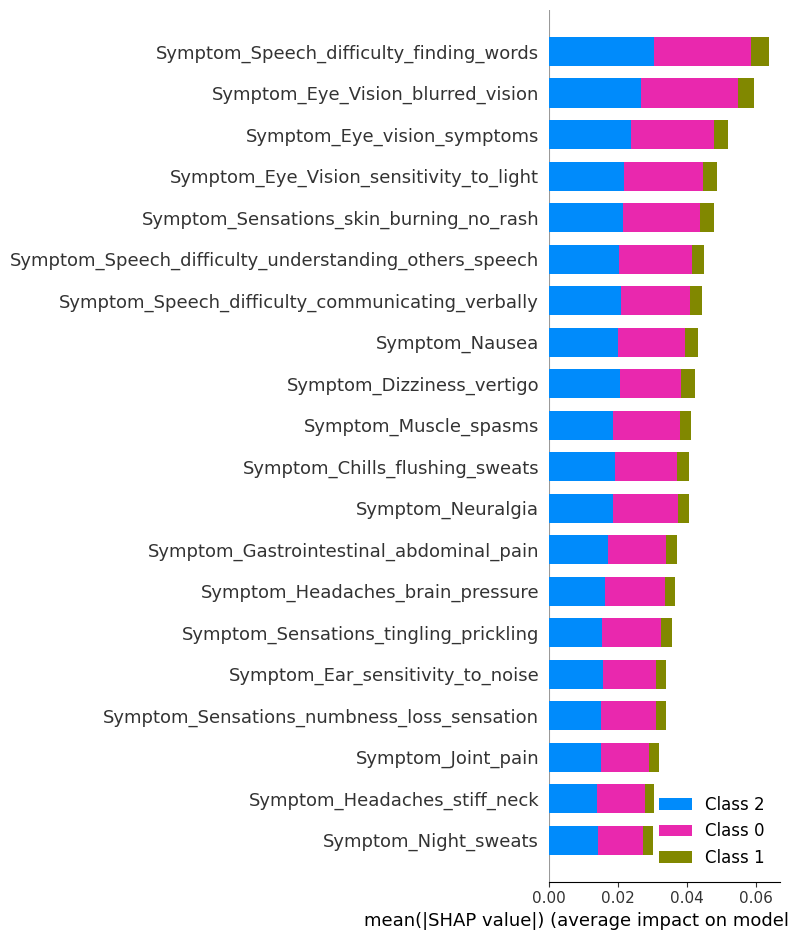

In [24]:
shap.summary_plot(
    [shap_values_tuned.values[:,:,0], shap_values_tuned.values[:,:,1], shap_values_tuned.values[:,:,2]],
     plot_type='bar', features=train.values, feature_names = train.columns.to_list())

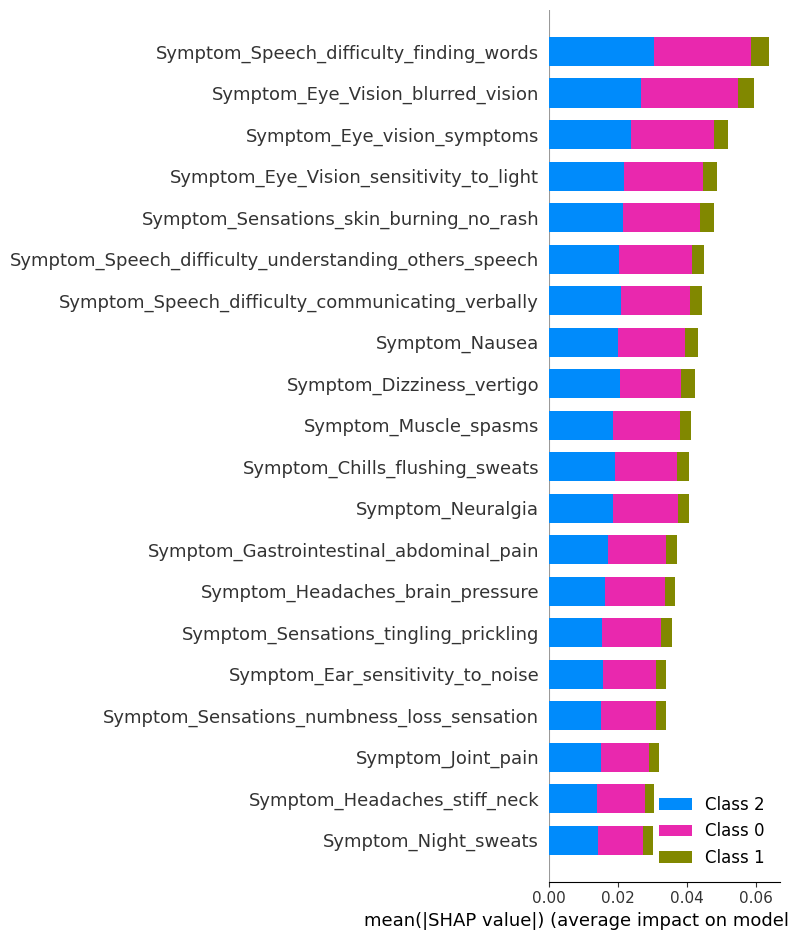

In [26]:
shap.summary_plot(
    [shap_values_tuned.values[:,:,0], shap_values_tuned.values[:,:,1], shap_values_tuned.values[:,:,2]],
     plot_type='bar', features=train.values, feature_names = train.columns.to_list())

##### Here we build a table of summary metrics for each cluster, ordered by mean absolute shap value.

In [31]:
explanations = {}
for ci in range(len(communities)):

    com_index = [
        train.index.get_loc(i)
        for i in communities[ci]
    ]
    
    explanations[ci] = pd.DataFrame()
    explanations[ci]['symptom'] = train.columns
    # explanations[ci]['shap_mean_abs'] = abs(shap_values[com_index, :].values).mean(axis=0)
    # explanations[ci]['shap_sum_abs'] = abs(shap_values[com_index, :].values).sum(axis=0)
    # explanations[ci].sort_values(by='shap_mean_abs', ascending=False, inplace=True)
    explanations[ci]['shap_mean_abs'] = abs(shap_values_tuned[:, :, ci].values).mean(axis=0)
    explanations[ci]['shap_sum_abs'] = abs(shap_values_tuned[:, :, ci].values).sum(axis=0)
    explanations[ci].sort_values(by='shap_mean_abs', ascending=False, inplace=True)
    explanations[ci]['population_frequency'] = shap_values_tuned.data.sum(axis=0) / shap_values_tuned.data.shape[0]
    explanations[ci]['cluster_frequency'] = shap_values_tuned[com_index, :].data.sum(axis=0) / shap_values_tuned[com_index, :].data.shape[0]
    explanations[ci]['frequency_delta'] = explanations[ci]['cluster_frequency'] - explanations[ci]['population_frequency']
    

##### And we add a rank number for each symptom based on the shap values:

In [32]:
for ci in range(len(communities)):
    explanations[ci]['rank'] = [i for i in range(len(explanations[ci]))]

In [33]:
explanations[1].sort_values('frequency_delta', ascending=False)

,symptom,shap_mean_abs,shap_sum_abs,population_frequency,cluster_frequency,frequency_delta,rank
71,Symptom_Merged_temperature_other_temp_issues,0.001639,9.886139,0.693252,0.782450,0.089198,42
129,Symptom_Eye_Vision_sensitivity_to_light,0.003830,23.099253,0.666225,0.753199,0.086975,5
121,Symptom_Changes_in_voice,0.000917,5.532205,0.672525,0.758684,0.086158,81
88,Symptom_Diarrhea,0.001414,8.528304,0.483336,0.561243,0.077907,53
94,Symptom_Cough_with_mucus,0.000997,6.013568,0.550323,0.621572,0.071249,72
...,...,...,...,...,...,...,...
58,Symptom_Sensations_skin_burning_no_rash,0.003996,24.099675,0.137954,0.080439,-0.057515,3
38,Symptom_Heightened_smell,0.000423,2.551246,0.259327,0.201097,-0.058230,131
97,Symptom_Tightness_of_chest,0.000881,5.310680,0.166971,0.107861,-0.059110,86
66,Symptom_Sensations_facial_pressure_right,0.000300,1.807205,0.133643,0.062157,-0.071486,139


##### We can visualise the symptom frequency delta like this:

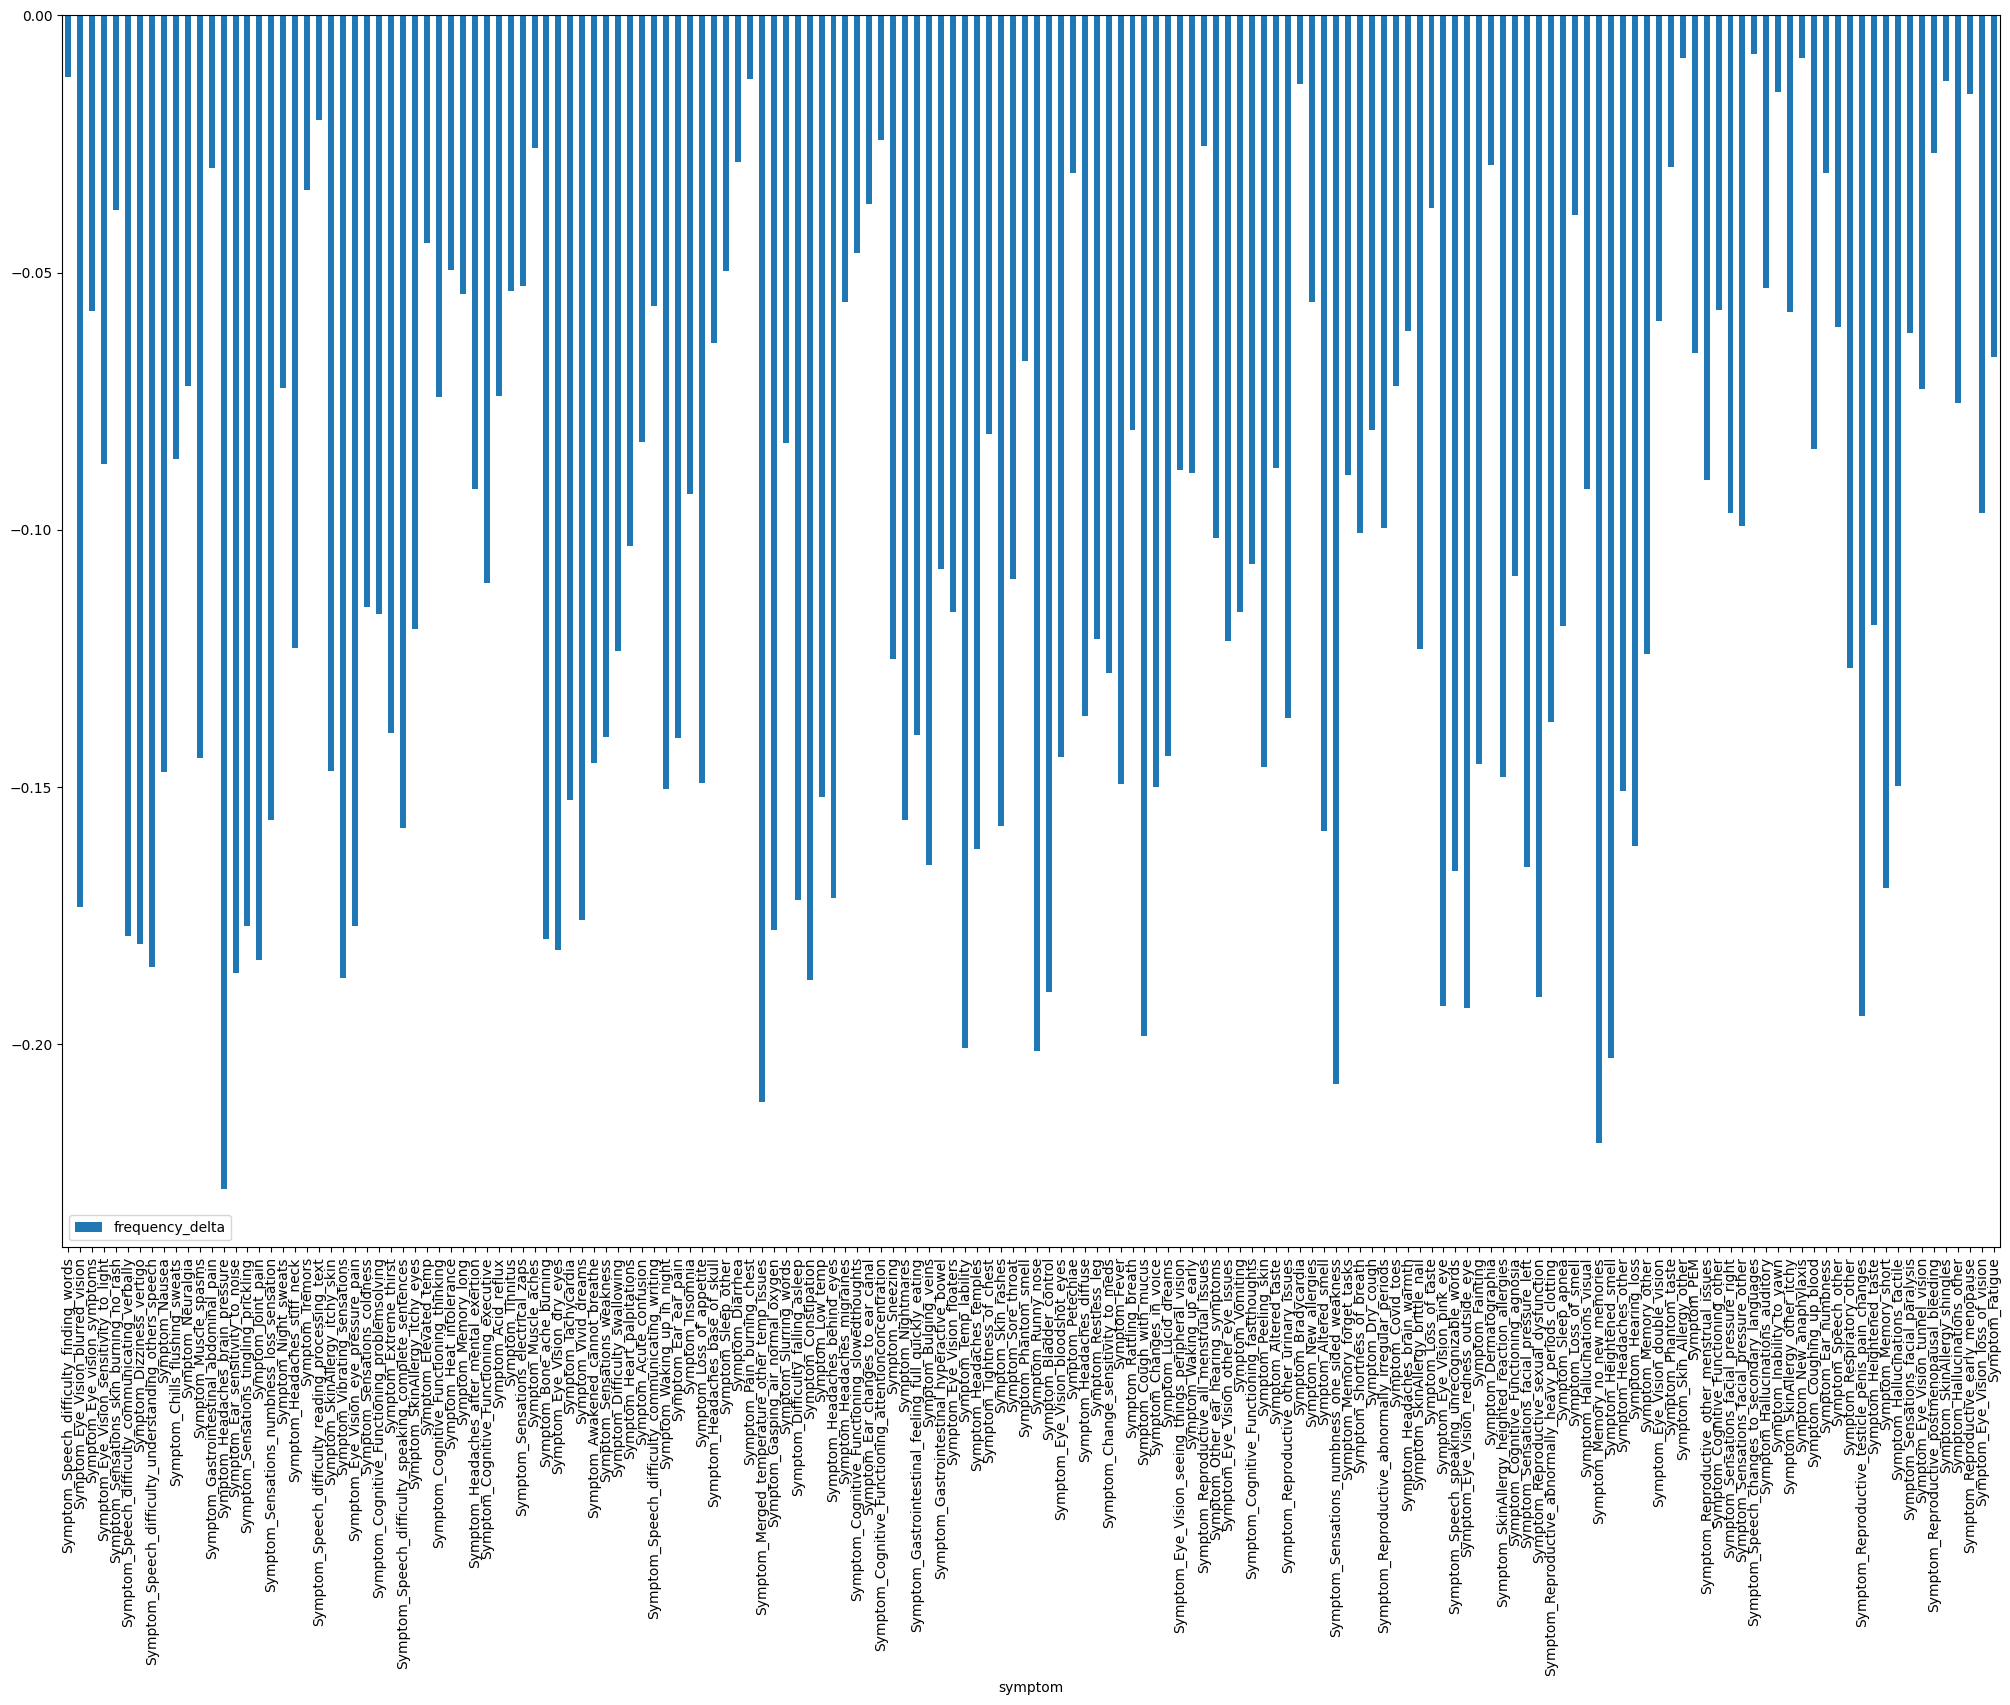

In [39]:
plt.figure(figsize=(25,16))
ax = plt.gca()
explanations[2].plot.bar(x='symptom', y='frequency_delta', ax=ax);

##### If we look at the shap symtpom ranks, comparing between pairs of clusters, we see that the rankings are very similar.

##### This means that the same features (or at least very similar) symptoms are important for predicting cluster membership across clusters.

#### This need investigating further: 
- do better clusters have more distinct shap rankings?
- does a different/better classifier use the symptoms differently to make predictions?
- are shap values the wrong thing to be using to try and capture this?

In [41]:
from itertools import combinations

In [42]:
cluster_pairs = list(combinations(range(len(communities)), 2))

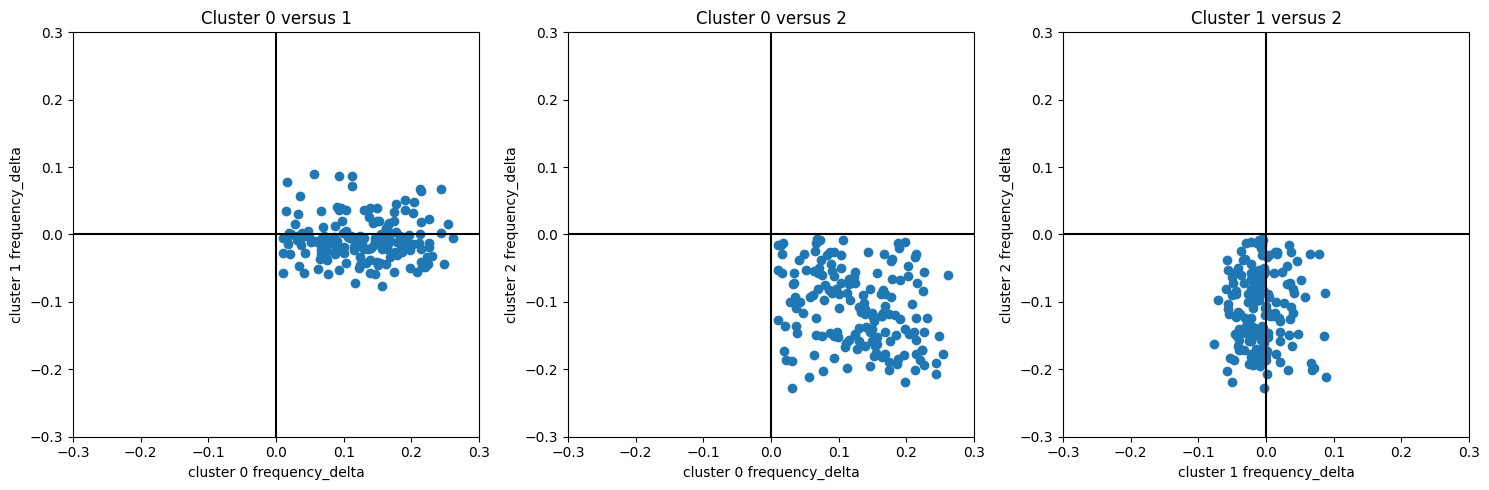

In [54]:
# metric = 'rank'
metric = 'frequency_delta'
x_min = -0.3
x_max = 0.3
y_min = -0.3
y_max = 0.3

plt.figure(figsize=(15, 5))
for i in range(len(communities)):

    ci = cluster_pairs[i][0]
    cj = cluster_pairs[i][1]
    temp = pd.merge(explanations[ci], explanations[cj], left_on='symptom', right_on='symptom')
    ax = plt.subplot(1,3,i+1)

    X = temp[metric +  '_x']
    Y = temp[metric +  '_y']

    plt.scatter(X, Y)
    # plt.plot([x_min, x_max], [y_min, y_max], c='k')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.title('Cluster %d versus %d' % (ci, cj))
    plt.xlabel('cluster %d ' % ci + metric)
    plt.ylabel('cluster %d ' % cj + metric)


plt.tight_layout();

##### Below was comparing SHAP values for two different RFs but there was a bug, so disregard for now.

In [139]:
from copy import copy
old_exp = copy(explanations)

In [159]:
for ci in range(len(communities)):
    old_exp[ci].symptom = old_exp[ci].symptom.astype(str)
    explanations[ci].symptom = explanations[ci].symptom.astype(str)
    old_exp[ci]['old_rank'] = [i for i in range(len(old_exp[ci]))]
    explanations[ci]['new_rank'] = [i for i in range(len(explanations[ci]))]

In [169]:
joined_exp = {}
for ci in range(len(communities)):
    joined_exp[ci] = pd.merge(old_exp[ci], explanations[ci], left_on='symptom', right_on='symptom')

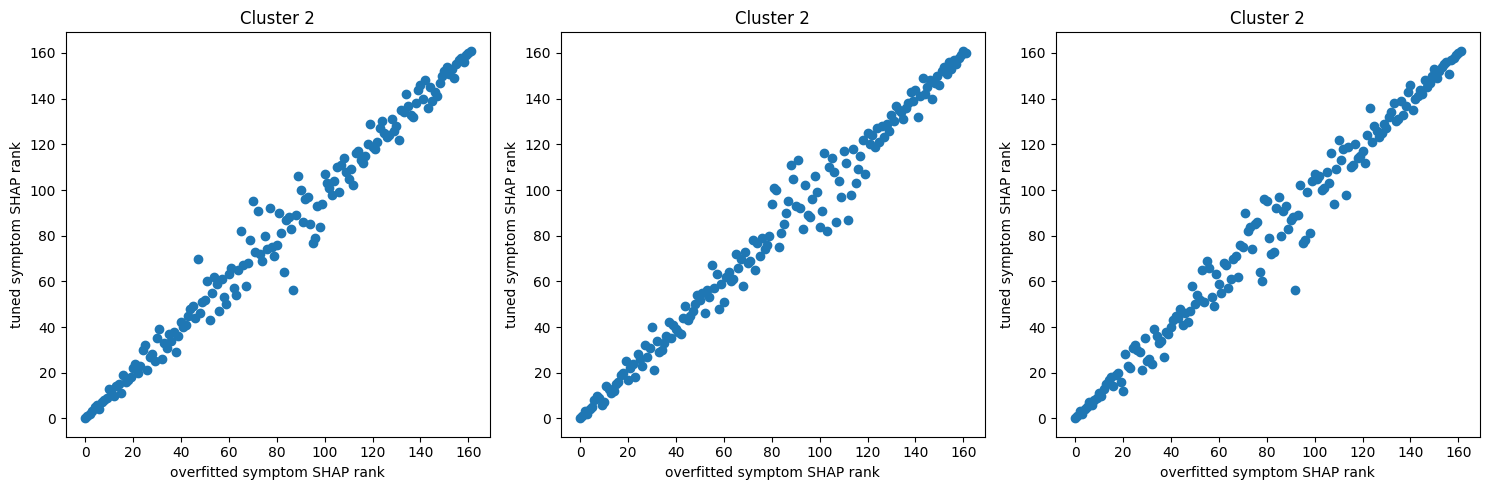

In [182]:
plt.figure(figsize=(15, 5))
for i in range(len(communities)):
    plt.subplot(1,3,i+1)
    plt.scatter(joined_exp[i].old_rank_x, joined_exp[i].new_rank)
    plt.title('Cluster %d' % ci)
    plt.xlabel('overfitted symptom SHAP rank')
    plt.ylabel('tuned symptom SHAP rank')


plt.tight_layout();